### Comparing GARCH conditional volatility to empirical rolling window vol

In [1]:
from arch import arch_model
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("utils")
import compare_strategies as cs
import dynamic_backtesting as db
from matplotlib.dates import DateFormatter
from matplotlib.dates import YearLocator
from cycler import cycler
import numpy as np
plt.style.use("seaborn")
plt.rcParams.update({
   "text.usetex": False,
   "font.family": ['Latin Modern Roman'],
   "xtick.labelsize": 16.0,
   "ytick.labelsize": 16.0,
   "axes.labelsize":  16.0,
   "legend.fontsize": 16.0
}) 

In [2]:
returns = yfinance.download("SPY", start="2010-01-01", end="2021-10-02")['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [3]:
pct_return = returns.pct_change().iloc[1:]*100

In [5]:
am = arch_model(pct_return)
res_vanilla = am.fit(disp="off")

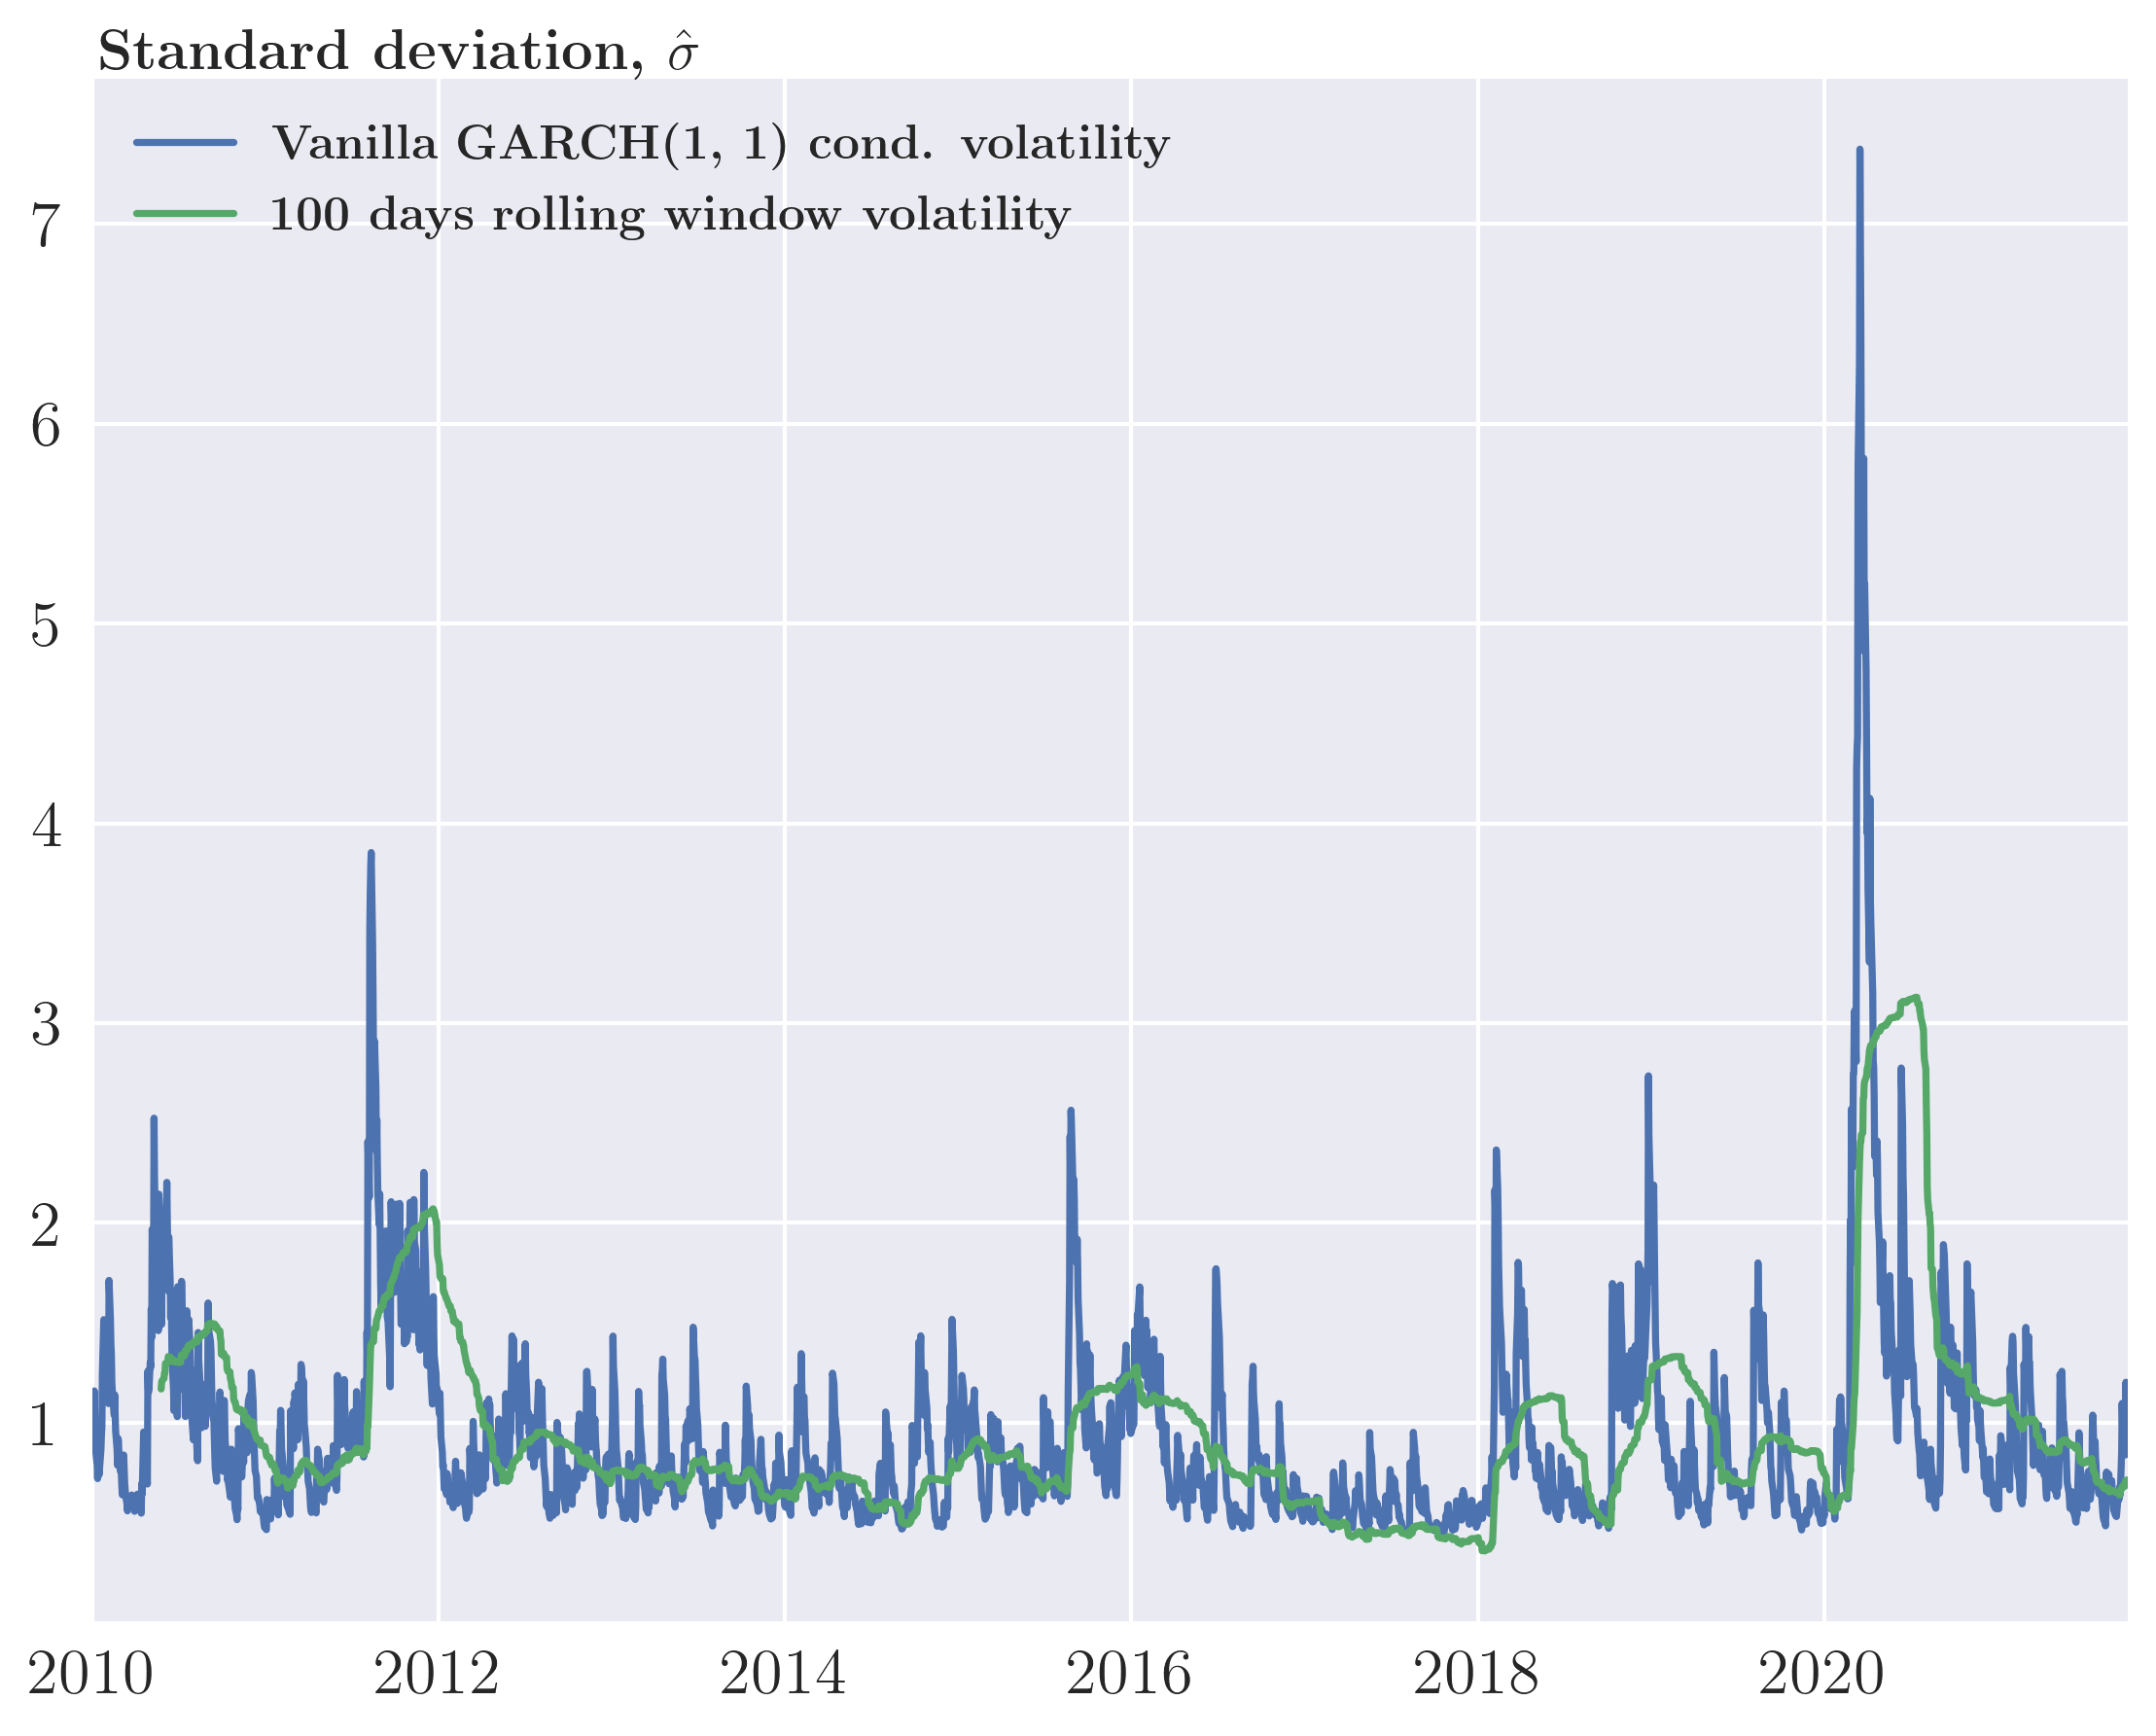

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), dpi=300)
ax.plot(res_vanilla.conditional_volatility, label=r"\textbf{Vanilla GARCH(1, 1) cond. volatility}")
ax.plot(pct_return.rolling(100).std(), label=r"\textbf{100 days rolling window volatility}")
ax.set_ylabel(r"\textbf{Standard deviation, $\hat{\sigma}$", loc='top', rotation = 0, labelpad = -165,size=14) 
ax.legend(fontsize=12)
ax.set_xlim("2010","2021-10-02")
fig.savefig("../Description of data/GarchvsEmpirical_vol.png",bbox_inches = 'tight')

### Using it for backtesting

In [2]:
# Get return data
tickers = ['IVV', 'TLT', 'BZ=F']
start="2008-01-01"
end="2021-10-02"
number_of_out_of_sample_days=250*4
len_rolling_window = 100

out_of_sample, in_sample, sigmas, residuals, params_dict = db.split_fit_parse(tickers, start, end, number_of_out_of_sample_days, model_type="sGARCH11")

['IVV', 'TLT', 'BZ=F']


### First, no regularization

In [3]:
# GARCH cond var estimate
Omega_ts_no_reg = db.calc_Omega_ts(out_of_sample_returns=out_of_sample, in_sample_returns=in_sample,
                             in_sample_sigmas=sigmas, in_sample_residuals=residuals, **params_dict, regularizer=0.0)

In [4]:
GARCH_weights_no_reg = db.calc_weights_garch_no_trading_cost(Omega_ts_no_reg)

weight_index = pd.to_datetime(in_sample.index[[-1]].union(out_of_sample.index))
GARCH_weights_no_reg = pd.DataFrame(GARCH_weights_no_reg, columns=tickers, index=weight_index)

In [5]:
# Construct dataset with burn-in period 
returns_for_rolling = pd.concat([in_sample.iloc[-len_rolling_window-1:-1], out_of_sample])

In [6]:
# Naive rolling window estimate
rolling_estimate = returns_for_rolling.rolling(len_rolling_window).cov().values[(len_rolling_window-1)*3:]
naive_covars = []

for i, val in enumerate(rolling_estimate):
    if i % 3 == 0 and i !=0:
        naive_covars.append(rolling_estimate[i-3:i])

In [13]:
rolling_weights_no_reg = pd.DataFrame(db.calc_weights_garch_no_trading_cost(naive_covars, False),
                            index=GARCH_weights_no_reg.index,
                            columns=GARCH_weights_no_reg.columns)

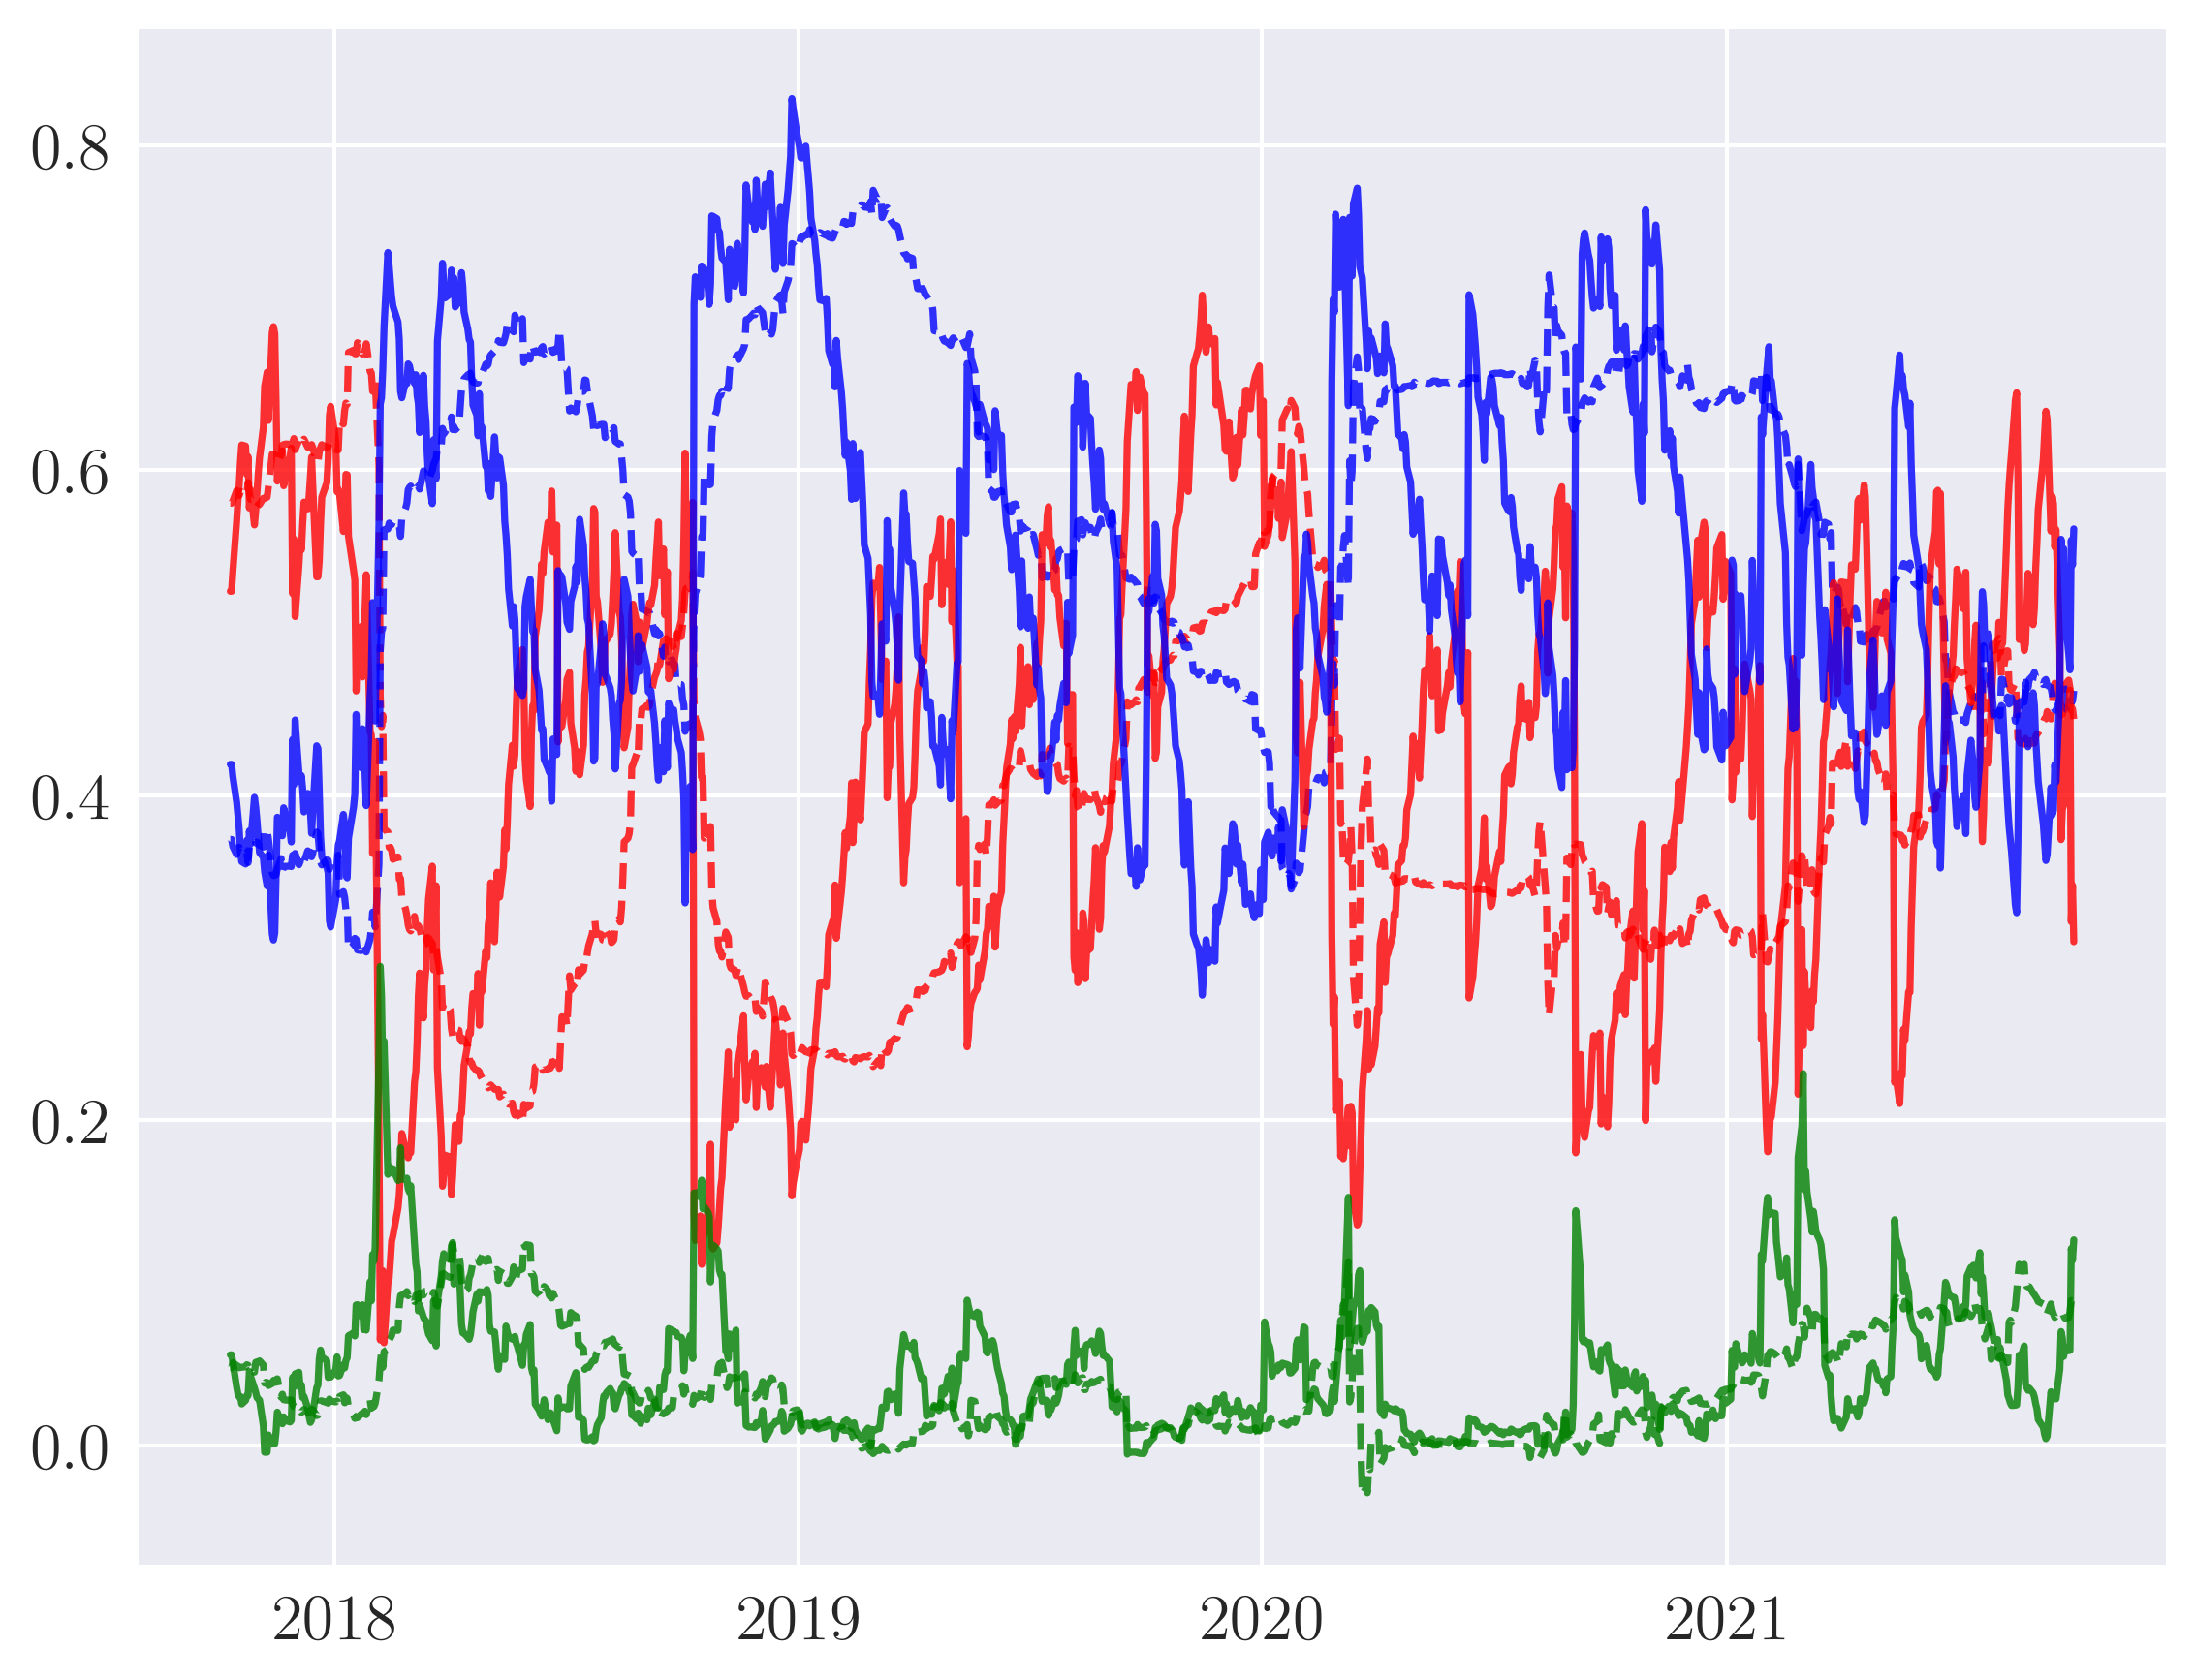

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=300)
ax.set_prop_cycle(cycler(color=['red', 'blue', 'green']))
ax.plot(rolling_weights_no_reg, linestyle="--", alpha=0.8)
ax.plot(GARCH_weights_no_reg, alpha=0.8)
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

In [26]:
cum_returns_garch_no_reg, perf_garch_no_reg = cs.performance_table(GARCH_weights_no_reg, out_of_sample,
                                                                   Omega_ts_no_reg, strategy_name="GARCH vol, not regularized")

In [25]:
cum_returns_rolling_no_reg, perf_rolling_no_reg = cs.performance_table(rolling_weights_no_reg, out_of_sample,
                                                                       Omega_ts_no_reg, strategy_name="Rolling vol, not regularized")

Result: Rolling window estimate actually just as good as GARCH before trading costs - and clearly beating it after trading costs

### Now, we do the same but with a 50% regularization applied

##### Regularizing rolling estimate

In [17]:
# Regularize vol estimate by 50%
regularizer = 0.5
ones = np.identity(len(naive_covars[0]))
naive_covars_reg = [ones * regularizer + covar_estimate * (1 - regularizer) for covar_estimate in naive_covars]

In [18]:
rolling_weights_reg = pd.DataFrame(db.calc_weights_garch_no_trading_cost(naive_covars_reg, False),
                            index=GARCH_weights_no_reg.index,
                            columns=GARCH_weights_no_reg.columns)

##### Regularizing GARCH

In [19]:
# GARCH cond var estimate
Omega_ts_reg = db.calc_Omega_ts(out_of_sample_returns=out_of_sample, in_sample_returns=in_sample,
                             in_sample_sigmas=sigmas, in_sample_residuals=residuals, **params_dict, regularizer=0.5)
GARCH_weights_reg = db.calc_weights_garch_no_trading_cost(Omega_ts_reg)

weight_index = pd.to_datetime(in_sample.index[[-1]].union(out_of_sample.index))
GARCH_weights_reg = pd.DataFrame(GARCH_weights_reg, columns=tickers, index=weight_index)

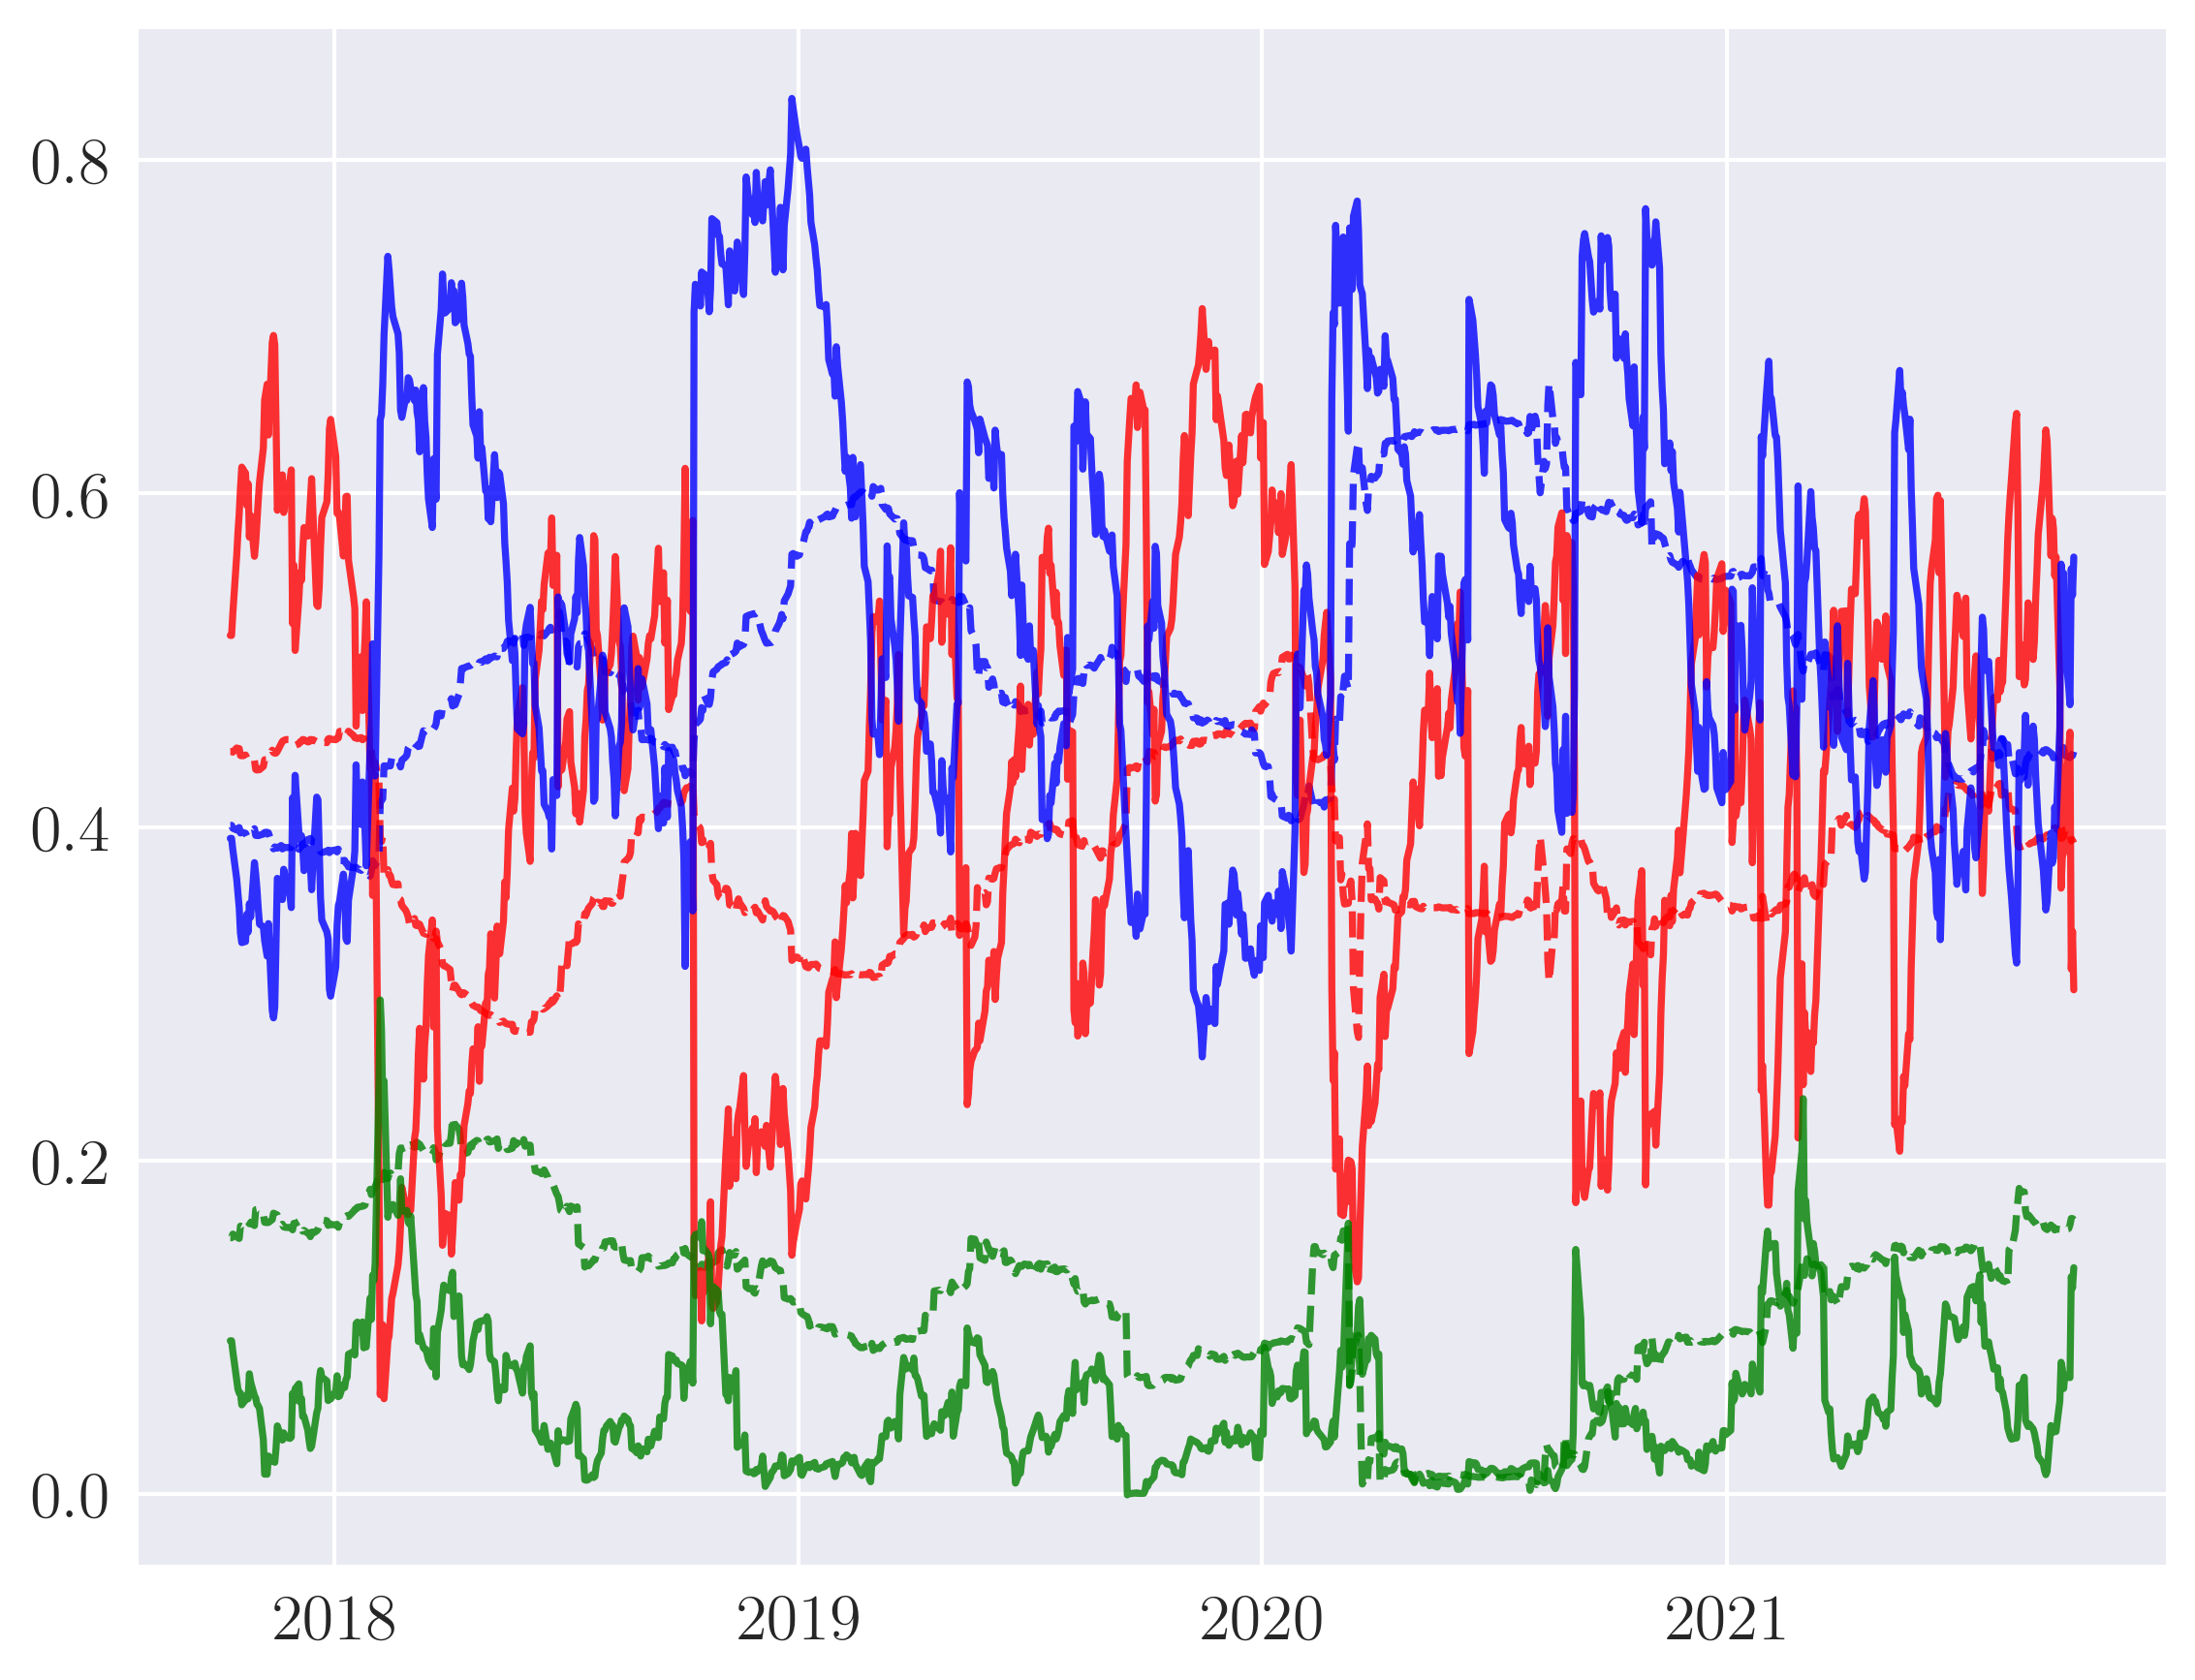

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=300)
ax.set_prop_cycle(cycler(color=['red', 'blue', 'green']))
ax.plot(rolling_weights_reg, linestyle="--", alpha=0.8)
ax.plot(GARCH_weights_reg, alpha=0.8)
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

In [23]:
cum_returns_rolling_reg, perf_rolling_reg = cs.performance_table(Naive_reg, out_of_sample, Omega_ts_reg, strategy_name="Rolling vol, regularized")

In [27]:
cum_returns_GARCH_reg, perf_GARCH_reg = cs.performance_table(GARCH_weights_reg, out_of_sample, Omega_ts_reg, strategy_name="GARCH vol, not regularized")

In [28]:
perf_GARCH_reg

,Ann. standard deviation,Ann. return,Ann. Sharpe ratio
"GARCH vol, not regularized",0.098033,0.106924,1.090695
Equal_weight,0.177075,0.135784,0.766817
BnH,0.110237,0.123957,1.124459
"GARCH vol, not regularized TC",0.130591,-0.071047,-0.544046
Equal_weight TC,0.184148,0.044282,0.240468
BnH TC,0.110237,0.123957,1.124459


In [29]:
perf_rolling_reg

,Ann. standard deviation,Ann. return,Ann. Sharpe ratio
"Rolling vol, regularized",0.101750,0.105614,1.037973
Equal_weight,0.177075,0.135784,0.766817
BnH,0.110898,0.117931,1.063425
"Rolling vol, regularized TC",0.110357,0.042385,0.384069
Equal_weight TC,0.184148,0.044282,0.240468
BnH TC,0.110898,0.117931,1.063425


In [30]:
perf_rolling_no_reg

,Ann. standard deviation,Ann. return,Ann. Sharpe ratio
"Rolling vol, not regularized",0.097009,0.102443,1.056016
Equal_weight,0.177075,0.135784,0.766817
BnH,0.114629,0.129629,1.130851
"Rolling vol, not regularized TC",0.106012,0.031182,0.294138
Equal_weight TC,0.184171,0.044255,0.240294
BnH TC,0.114629,0.129629,1.130851
